# Use Case:  Language Translator
dataset consisting of pairs of English sentences and their French translation,

In [27]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
from __future__ import print_function

import tensorflow as tf
from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np


fra.txt


In [29]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 512  # Latent dimensionality of the encoding space.
num_samples = 20000  # Number of samples to train on.
# Path to the data txt file on disk.
#data_path = '/content/drive/MyDrive/RI_projekat/fra.txt'
data_path = 'fra.txt'

In [30]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

In [31]:
lines

['Go.\tVa !',
 'Hi.\tSalut !',
 'Run!\tCours\u202f!',
 'Run!\tCourez\u202f!',
 'Who?\tQui ?',
 'Wow!\tÇa alors\u202f!',
 'Fire!\tAu feu !',
 "Help!\tÀ l'aide\u202f!",
 'Jump.\tSaute.',
 'Stop!\tÇa suffit\u202f!',
 'Stop!\tStop\u202f!',
 'Stop!\tArrête-toi !',
 'Wait!\tAttends !',
 'Wait!\tAttendez !',
 'Go on.\tPoursuis.',
 'Go on.\tContinuez.',
 'Go on.\tPoursuivez.',
 'Hello!\tBonjour !',
 'Hello!\tSalut !',
 'I see.\tJe comprends.',
 "I try.\tJ'essaye.",
 "I won!\tJ'ai gagné !",
 "I won!\tJe l'ai emporté !",
 'I won.\tJ’ai gagné.',
 'Oh no!\tOh non !',
 'Attack!\tAttaque !',
 'Attack!\tAttaquez !',
 'Cheers!\tSanté !',
 'Cheers!\tÀ votre santé !',
 'Cheers!\tMerci !',
 'Cheers!\tTchin-tchin !',
 'Get up.\tLève-toi.',
 'Go now.\tVa, maintenant.',
 'Go now.\tAllez-y maintenant.',
 'Go now.\tVas-y maintenant.',
 "Got it!\tJ'ai pigé !",
 'Got it!\tCompris !',
 'Got it?\tPigé\u202f?',
 'Got it?\tCompris\u202f?',
 "Got it?\tT'as capté\u202f?",
 'Hop in.\tMonte.',
 'Hop in.\tMontez.',
 'Hu

In [32]:
len(lines)

167131

In [33]:
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)


In [34]:
len(input_characters)

74

In [35]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [36]:
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 20000
Number of unique input tokens: 74
Number of unique output tokens: 102
Max sequence length for inputs: 18
Max sequence length for outputs: 59


In [37]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])


In [38]:
"""Turn the sentences into 3 Numpy arrays, encoder_input_data, decoder_input_data, decoder_target_data:

encoder_input_data is a 3D array of shape (num_pairs, max_english_sentence_length, num_english_characters) containing a one-hot vectorization of the English sentences
decoder_input_data is a 3D array of shape (num_pairs, max_french_sentence_length, num_french_characters) containing a one-hot vectorization of the French sentences
decoder_target_data is the same as decoder_input_data but offset by one timestep. decoder_target_data[:, t, :] will be the same as decoder_input_data[:, t + 1, :]
"""

encoder_input_data = np.zeros((len(input_texts), max_encoder_seq_length, num_encoder_tokens),dtype='float32')
decoder_input_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens),dtype='float32')
decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens),dtype='float32')


In [39]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data[i, t:, target_token_index[' ']] = 1.

In [40]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_outputs = tf.keras.layers.Dropout(0.2)(encoder_outputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

In [41]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_outputs = tf.keras.layers.Dropout(0.2)(decoder_outputs)

decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [42]:
#Train a basic LSTM-based Seq2Seq model to predict decoder_target_data given encoder_input_data and decoder_input_data

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [43]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, None, 74)]           0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, None, 102)]          0         []                            
                                                                                                  
 lstm_2 (LSTM)               [(None, 512),                1202176   ['input_5[0][0]']             
                              (None, 512),                                                        
                              (None, 512)]                                                        
                                                                                            

In [44]:
# Run training

history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# Save model
model.save('s2s.h5')

Epoch 1/100
250/250 [==============================] - 11s 27ms/step - loss: 1.2430 - accuracy: 0.7021 - val_loss: 1.1889 - val_accuracy: 0.6750
Epoch 2/100
250/250 [==============================] - 6s 25ms/step - loss: 0.9808 - accuracy: 0.7344 - val_loss: 0.9875 - val_accuracy: 0.7186
Epoch 3/100
250/250 [==============================] - 6s 22ms/step - loss: 0.7720 - accuracy: 0.7759 - val_loss: 0.8560 - val_accuracy: 0.7491
Epoch 4/100
250/250 [==============================] - 6s 22ms/step - loss: 0.7011 - accuracy: 0.7939 - val_loss: 0.7993 - val_accuracy: 0.7649
Epoch 5/100
250/250 [==============================] - 6s 26ms/step - loss: 0.6578 - accuracy: 0.8062 - val_loss: 0.7500 - val_accuracy: 0.7817
Epoch 6/100
250/250 [==============================] - 6s 22ms/step - loss: 0.6224 - accuracy: 0.8171 - val_loss: 0.7256 - val_accuracy: 0.7859
Epoch 7/100
250/250 [==============================] - 6s 25ms/step - loss: 0.5929 - accuracy: 0.8254 - val_loss: 0.6978 - val_accuracy

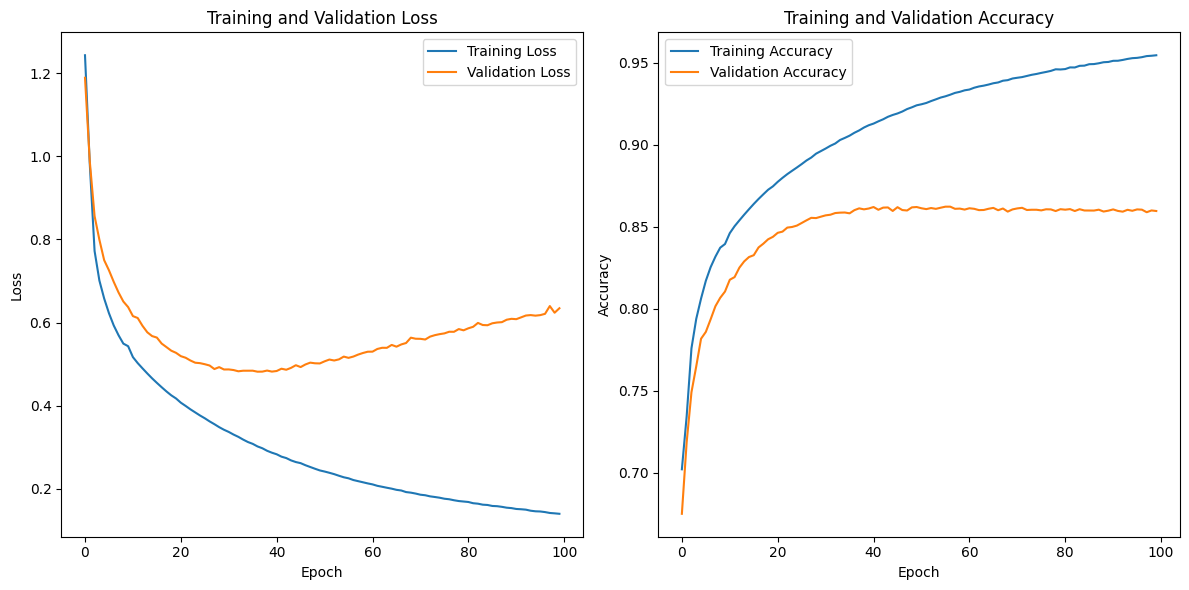

In [45]:
import matplotlib.pyplot as plt

# Extract data from the training history
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create subplots for loss and accuracy
plt.figure(figsize=(12, 6))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [46]:
# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

In [47]:
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)


In [48]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


In [49]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [50]:
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

1/1 [==============================] - 0s 22ms/step
-
Input sentence: Go.
Decoded sentence: Pare !

1/1 [==============================] - 0s 36ms/step
-
Input sentence: Hi.
Decoded sentence: Salut !

1/1 [==============================] - 0s 30ms/step
-
Input sentence: Run!
Decoded sentence: Pare-!

1/1 [==============================] - 0s 30ms/step
-
Input sentence: Run!
Decoded sentence: Pare-!

1/1 [==============================] - 0s 39ms/step
-
Input sentence: Who?
Decoded sentence: Qui est-ce ?

1/1 [==============================] - 0s 20ms/step
-
Input sentence: Wow!
Decoded sentence: Attendez !

1/1 [==============================] - 0s 22ms/step
-
Input sentence: Fire!
Decoded sentence: Allons-y !

1/1 [==============================] - 0s 27ms/step
-
Input sentence: Help!
Decoded sentence: Aide-moi.

1/1 [==============================] - 0s 20ms/step
-
Input sentence: Jump.
Decoded sentence: Laissez-moi m'en aller !

1/1 [==============================] - 0s 22ms/step
-
